
# This is a collaboratory, where you can find the code of the final project (Project 4) of the course : **Computer Vision** 

In [1]:
# Mount google drive :

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Unzip the dataset and save it to the path "/content/imagedb_btsd" :
import os
import zipfile

local_zip = '/content/drive/MyDrive/cv_proj_4_dataset/imagedb_btsd.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/imagedb_btsd')
zip_ref.close()

In [3]:
# Select the folder "imagedb" as the training folder
# and the folder "imagedb_test" as the testing folder :

base_dir = '/content/imagedb_btsd'

train_dir = os.path.join(base_dir, 'imagedb')
test_dir = os.path.join(base_dir, 'imagedb_test')

In [4]:
import os
import random
import skimage.io
from skimage import data, io, filters
# import skimage.data
# import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Allow image embeding in notebook
%matplotlib inline

In [5]:
# Using a function to return two lists (images and labels) from the train_dir :
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(int(d))
    return images, labels

In [6]:
# Extract images and labels fom training dataset :

images, labels = load_data(train_dir)

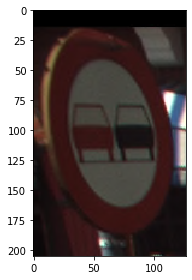

31


In [7]:
# check images and labels :
io.imshow(images[20])
io.show()
print(labels[20])

In [8]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 34
Total Images: 3056


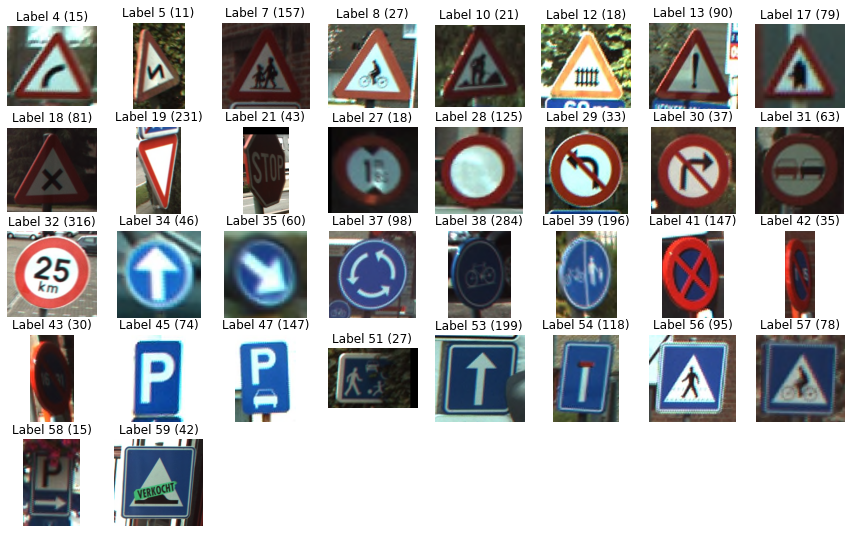

In [9]:
# Display the first image of each label :

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

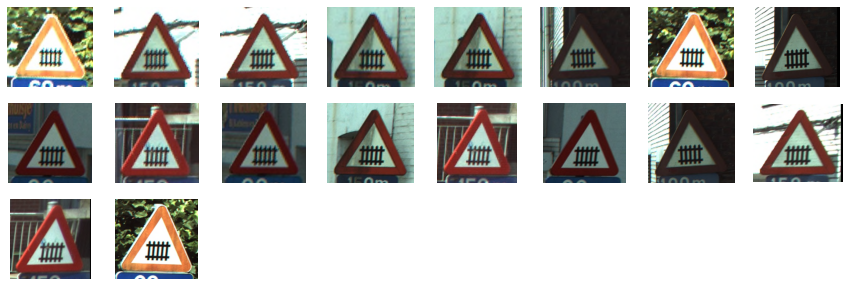

In [10]:
# Checking all the images of a specific label :

# e.g. for label :
# label_ch = 32
# label_ch = 27
label_ch = 12

def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, label_ch)

Using transfer learning :

In [11]:
from keras.applications import vgg16
#Load the VGG model
vgg_conv = vgg16.VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(256, 256, 3))

In [12]:
# # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# vgg_conv2 = vgg16.VGG16(weights='imagenet', 
#                  include_top=True)

# for layer in vgg_conv2.layers:
#     print(layer, layer.trainable)

# from keras import models

# model2 = models.Sequential()
 
# # Add the vgg convolutional base model
# model2.add(vgg_conv2)

# model2.summary()
 
# # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [13]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fd21fbc8210> False
<keras.layers.convolutional.Conv2D object at 0x7fd213f55910> False
<keras.layers.convolutional.Conv2D object at 0x7fd213f02110> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd21360ac90> False
<keras.layers.convolutional.Conv2D object at 0x7fd213613350> False
<keras.layers.convolutional.Conv2D object at 0x7fd200675b50> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd213655090> False
<keras.layers.convolutional.Conv2D object at 0x7fd20067c890> False
<keras.layers.convolutional.Conv2D object at 0x7fd20067d1d0> False
<keras.layers.convolutional.Conv2D object at 0x7fd200681e50> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd213613c90> False
<keras.layers.convolutional.Conv2D object at 0x7fd2136553d0> False
<keras.layers.convolutional.Conv2D object at 0x7fd2136184d0> False
<keras.layers.convolutional.Conv2D object at 0x7fd20066afd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd200686b10>

In [14]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(34, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 34)                34850     
                                                                 
Total params: 48,304,994
Trainable params: 40,669,730
Non-trainable params: 7,635,264
_________________________________________________________________


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range = 90,
                                   horizontal_flip=True,
                                  #  vertical_flip = True,
                                   brightness_range=[0.2,1.0],
                                   zoom_range=[0.5,1.0],
                                   preprocessing_function=vgg16.preprocess_input, 
                                   validation_split=0.2)
#train_datagen  = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# --------------------
# Flow training images in batches using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=40,
                                                    class_mode='categorical',
                                                    # color_mode='grayscale',
                                                    target_size=(256,256),
                                                    shuffle=True,
                                                    subset='training', seed=1)     
# --------------------
# Flow validation images in batches using test_datagen generator
# --------------------
validation_generator =  train_datagen.flow_from_directory(train_dir,
                                                        batch_size=40,
                                                        class_mode='categorical',
                                                        #  color_mode='grayscale',
                                                         target_size=(256,256),
                                                        subset='validation', seed=1) 

Found 2457 images belonging to 34 classes.
Found 599 images belonging to 34 classes.


In [16]:
model_name = 'pretrained_VGG16_batch_40_epochs_60'

In [17]:
# Apply callbacks :

my_callbacks = []

save_best_callback = tf.keras.callbacks.ModelCheckpoint(f'' + model_name + '.hdf5', save_best_only=True, verbose=1)
my_callbacks.append(save_best_callback)

early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
my_callbacks.append(early_stop_callback)

In [18]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.adam_v2.Adam(learning_rate=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=60,
      validation_data=validation_generator,
      verbose=1,
      callbacks = my_callbacks)
 
# # Save the model
# model_name = 'pretrained_VGG16_batch_40_epochs_60'
# model.save(model_name + '.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/60
62/61 [==============================] - ETA: 0s - loss: 3.6045 - acc: 0.2226
Epoch 00001: val_loss improved from inf to 2.05529, saving model to pretrained_VGG16_batch_40_epochs_60.hdf5
61/61 [==============================] - 81s 1s/step - loss: 3.6045 - acc: 0.2226 - val_loss: 2.0553 - val_acc: 0.4658
Epoch 2/60
62/61 [==============================] - ETA: 0s - loss: 1.7720 - acc: 0.5230
Epoch 00002: val_loss improved from 2.05529 to 1.05949, saving model to pretrained_VGG16_batch_40_epochs_60.hdf5
61/61 [==============================] - 54s 873ms/step - loss: 1.7720 - acc: 0.5230 - val_loss: 1.0595 - val_acc: 0.6878
Epoch 3/60
62/61 [==============================] - ETA: 0s - loss: 1.0923 - acc: 0.6939
Epoch 00003: val_loss improved from 1.05949 to 0.85979, saving model to pretrained_VGG16_batch_40_epochs_60.hdf5
61/61 [==============================] - 53s 868ms/step - loss: 1.0923 - acc: 0.6939 - val_loss: 0.8598 - val_acc: 0.7679
Epoch 4/60
62/61 [=================

In [19]:
# # Saving the model to a google drive folder :

# import shutil
# shutil.copy('/content/'+ model_name +'.hdf5','/content/drive/MyDrive/CV_Project_4_saved_models/'+ model_name)


In [20]:
test_datagen  = ImageDataGenerator(rescale=1./255)

# --------------------
# Flow validation images in batches using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                        batch_size=10,
                                                        class_mode='categorical',
                                                        #  color_mode='grayscale',
                                                         target_size=(256,256))
# Testing the CNN on testing data : 
loss, acc = model.evaluate(test_generator)

Found 2149 images belonging to 34 classes.
215/215 [==============================] - 21s 86ms/step - loss: 6.1115 - acc: 0.0237


In [21]:
# # Loading the model from the google drive folder : 

# model_loaded = models.load_model('/content/drive/MyDrive/CV_Project_4_saved_models/' + model_name)
# model_loaded.summary()